## Copy this notebook (if using Colab) via `File -> Save a Copy in Drive`.

## You can do this assignment outside of Colab (using your local Python installation) via `File -> Download`.

## <u>**Use the "Text" blocks to provide explanations wherever you find them necessary. Highlight your answers inside these text fields to ensure that we don't miss it while grading your HW.**</u>

## **Setup**

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and uploading it to your drive), you can skip this section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# First mount your drive before running these cells.
# Create a folder for the this HW and change to that dir
%cd drive/MyDrive/CSE519

# Download data from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
# Create a new API token under "Account" in the kaggle webpage and download the json file
# Upload the file by clicking on the browse
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c commonlit-evaluate-student-summaries

# Alternate: download data using gdown (if having issues with Kaggle)

In [ ]:
!pip install gdown

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=164sQHZYvxU2XXPokrjzqv9MCGAMHaCIM'
gdown.download(url)

# Extract data and install packages (regardless of data acquisition method)

In [ ]:
!unzip commonlit-evaluate-student-summaries.zip

In [1]:
### TODO: Install required packages
### Student's code here
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
### END

## **Section 1: Library and Data Imports (Q1, 5 points)**

- Import your libraries and join the data from both `summaries_train.csv` and `prompts_train.csv` into a single dataframe with the same structure as `use_cols`. Print the head of the dataframe. **Do not modify `use_cols`.**

In [3]:
### TODO: Load required packages
### Student's code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from nltk import word_tokenize, pos_tag
import re

###

In [ ]:
use_cols = ["student_id",
            "prompt_id",
            "text",
            "content",
            "wording",
            "prompt_question",
            "prompt_title",
            "prompt_text"
           ]
dtypes = {
        'student_id':                                    'string',
        'prompt_id':                                     'string',
        'text':                                          'string',
        'content':                                       'Float64',
        'wording':                                       'Float64',
        'prompt_question':                               'string',
        'prompt_title':                                  'string',
        'prompt_text':                                   'string',
        }

In [16]:
summary=pd.read_csv("summaries_train.csv")

In [17]:
summary.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [5]:
# Load data
summaries_train = pd.read_csv('summaries_train.csv')
prompts_train = pd.read_csv('prompts_train.csv')

# Merge the data
df = pd.merge(summaries_train, prompts_train, on='prompt_id')

In [24]:
df.describe()

,content,wording,numWordsText,numWordsPrompt,numDistinctWords,numCommonPrompt,numCommonQuestion,numCommonTitle,numSentences,numSyllable,readabilityScore,numChar,avg_word_length_text
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,74.811724,688.472017,4.318074,32.223029,5.461270,0.489184,4.318074,107.894348,306.135924,418.776971,4.563326
std,1.043569,1.036048,53.503992,173.787033,3.374373,19.610756,3.092933,0.818922,3.374373,78.616810,18.329814,307.833685,0.419488
min,-1.729859,-1.962614,22.000000,550.000000,1.000000,5.000000,0.000000,0.000000,1.000000,27.000000,158.922000,114.000000,3.258065
25%,-0.799545,-0.872720,39.000000,550.000000,2.000000,19.000000,3.000000,0.000000,2.000000,56.000000,295.960989,216.000000,4.275862
50%,-0.093814,-0.081769,58.000000,604.000000,3.000000,27.000000,5.000000,0.000000,3.000000,83.000000,307.739000,320.000000,4.545455
75%,0.499660,0.503833,92.000000,966.000000,5.000000,39.000000,7.000000,1.000000,5.000000,132.000000,317.998293,513.000000,4.827586
max,3.900326,4.310693,647.000000,966.000000,54.000000,225.000000,16.000000,4.000000,54.000000,990.000000,378.742571,3940.000000,7.015625


## **Section 2: Features (Q2 and Q3, 25 points total)**

In [6]:
def numWords(text):
    return len(text.split())
def distinctWords(text):
    return len(set(text.split()))
def commonWords(text1,text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    return len(words1.intersection(words2))
def mostCommonWords(text):
    array=text.split(' ')
    dict={}
    for x in array:
        if x not in dict:
            dict.update({x:1})
        else:
            dict.update({x:dict.get(x)+1})
    return max(dict, key=dict.get)
#My own features
def numSentences(text):
    sentences = re.split(r'[.!?]', text)
    return len(sentences) - sentences.count('')
def syllableCount(text):
    text = text.lower()
    count = 0
    vowels = "aeiouy"
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    if text:
        words = text.split()
        for word in words:
            word_count = 0
            if word[0] in vowels:
                word_count += 1
            for index in range(1, len(word)):
                if word[index] in vowels and word[index - 1] not in vowels:
                    word_count += 1
            if word.endswith("e"):
                word_count -= 1
            if word_count == 0:
                word_count += 1
            count += word_count
    return count
def fleschReading_ease(text):
    score = 206.835-(1.1015*(numWords(text)/numSentences(text))-84.6*(syllableCount(text)/numWords(text)))
    return score

def characterCount(text):
    return len(text)

def punctuationCount(text):
    punctuation_set = set("_=>`!\"#$%&'()*+,-./:;<?@[\\]^{|}~")
    count = 0
    for char in text:
        if char in punctuation_set:
            count += 1
    return count

#Specified
df['numWordsText'] = df['text'].apply(numWords)
df['numWordsPrompt'] = df['prompt_text'].apply(numWords)
df['numDistinctWordsText'] = df['text'].apply(distinctWords)
df['numDistinctWordsPrompt']=df['prompt_text'].apply(distinctWords)
df['numCommonPrompt'] = df.apply(lambda row: commonWords(row['text'],row['prompt_text']),axis=1)
df['numCommonQuestion'] = df.apply(lambda row: commonWords(row['text'],row['prompt_question']),axis=1)
df['numCommonTitle'] = df.apply(lambda row: commonWords(row['text'],row['prompt_title']),axis=1)
#My own
df['readabilityScore'] = df['text'].apply(fleschReading_ease)
df['numSentences'] = df['text'].apply(numSentences)
df['numSyllable'] = df['text'].apply(syllableCount)
df['numChar'] = df['text'].apply(characterCount)
df['avg_word_length_text'] = df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
df['punctuationCount'] = df['text'].apply(punctuationCount)


## **Section 3: Content and Wording (Q4, 10 points)**

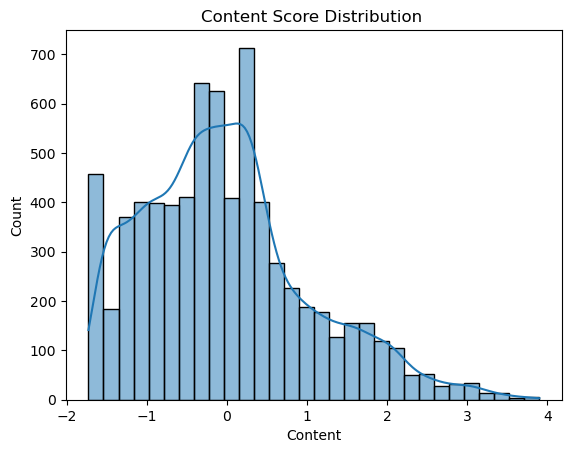

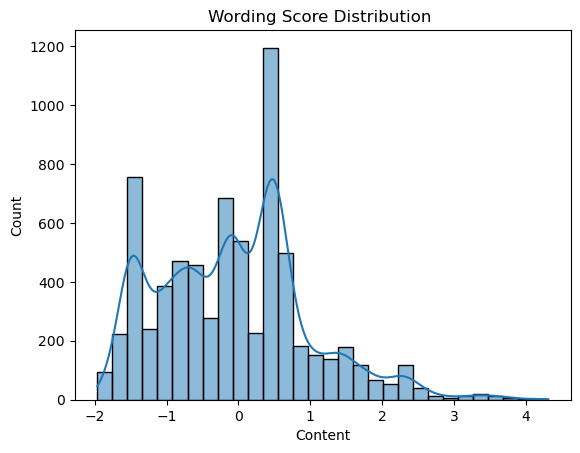

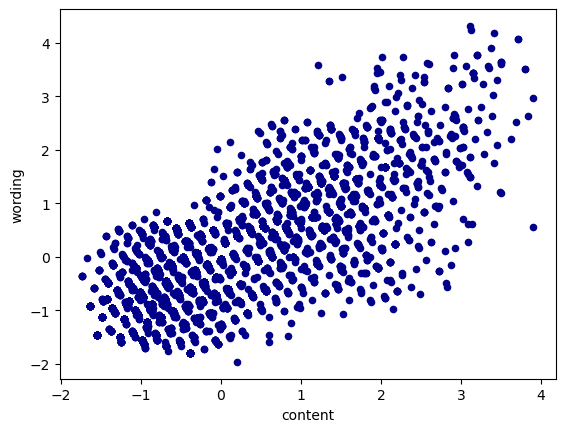

Correlation between content and wording:
0.7513804859701965


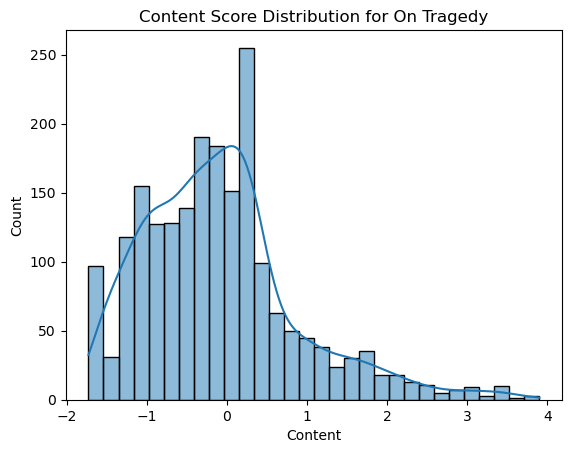

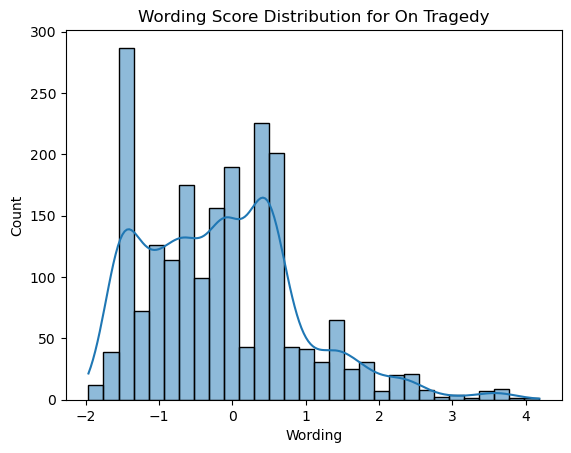

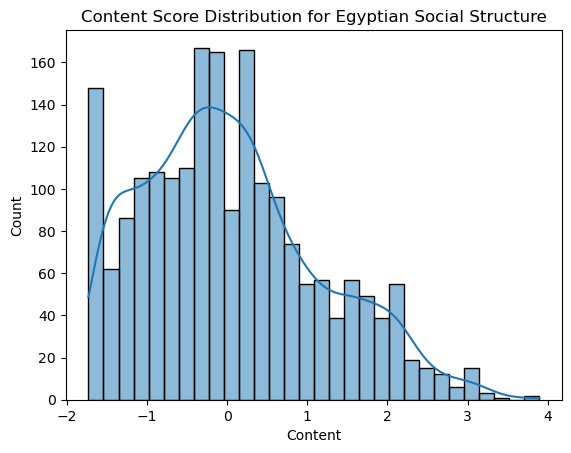

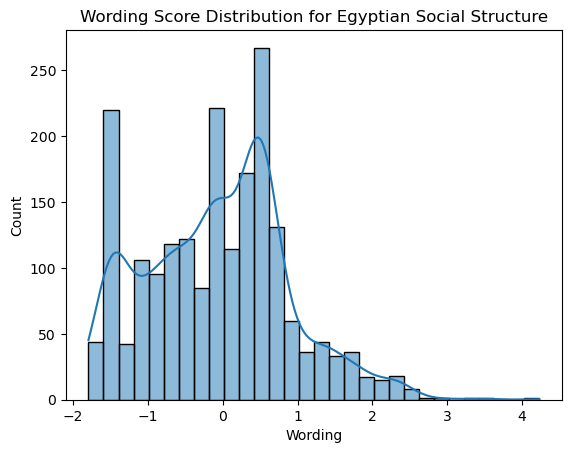

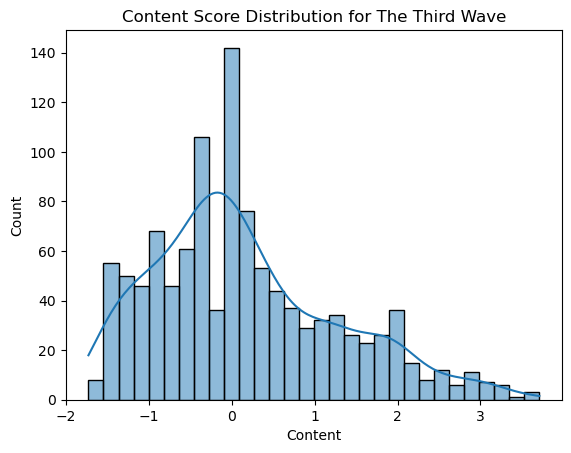

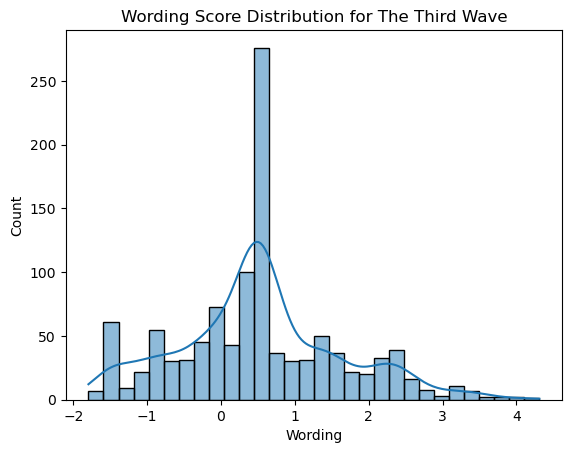

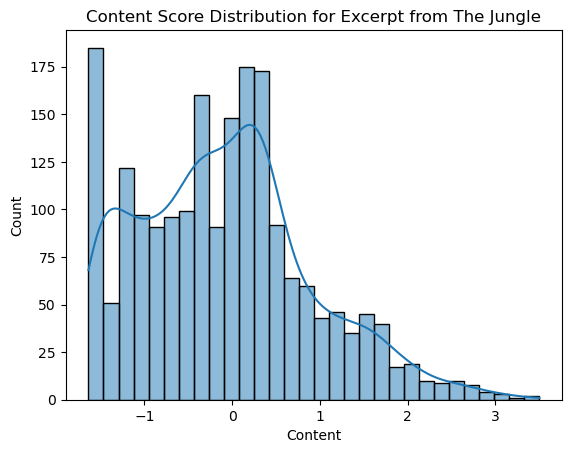

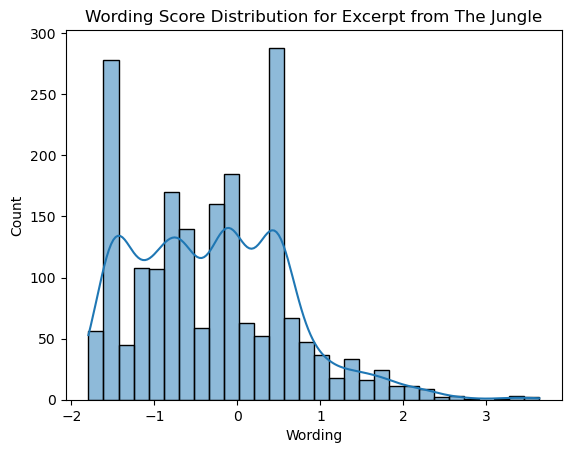

In [25]:
#Make Charts



#content
sns.histplot(df['content'], kde=True, bins=30)
plt.title(f'Content Score Distribution ')
plt.xlabel('Content')
plt.ylabel('Count')
plt.show()

#wording
sns.histplot(df['wording'], kde=True, bins=30)
plt.title(f'Wording Score Distribution ')
plt.xlabel('Content')
plt.ylabel('Count')
plt.show()

#scatter
scat = df.plot.scatter(x='content',y='wording',c='DarkBlue')
plt.show()
correlation = df['content'].corr(df['wording'])
print("Correlation between content and wording:")
print(correlation)


#List of specific prompt titles
prompt_titles = ["On Tragedy", "Egyptian Social Structure", "The Third Wave", "Excerpt from The Jungle"]

#Loop through each prompt title and create histograms for 'content' and 'wording'
for title in prompt_titles:
    filtered_data = df[df['prompt_title'] == title]

#Plot content score distribution
    sns.histplot(filtered_data['content'], kde=True, bins=30)
    plt.title(f'Content Score Distribution for {title}')
    plt.xlabel('Content')
    plt.ylabel('Count')
    plt.show()

#Plot wording score distribution
    sns.histplot(filtered_data['wording'], kde=True, bins=30)
    plt.title(f'Wording Score Distribution for {title}')
    plt.xlabel('Wording')
    plt.ylabel('Count')
    plt.show()

## **Section 4: Words in Good and Bad Essays (Q5, 10 points)**

In [45]:
# NEW
from collections import defaultdict
import math
from sklearn.feature_extraction.text import CountVectorizer

good_essays = df[(df['content'] > df['content'].quantile(0.75)) & 
                          (df['wording'] > df['wording'].quantile(0.75))]
bad_essays = df[(df['content'] < df['content'].quantile(0.25)) & 
                         (df['wording'] < df['wording'].quantile(0.25))]


# Vectorize the text data
text_column = 'text'  # Replace with the actual column name containing the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df[text_column])
words = vectorizer.get_feature_names_out()
 
# Calculate word frequencies for good and bad essays
word_counts_good = defaultdict(int)
word_counts_bad = defaultdict(int)
total_good = 0
total_bad = 0
 
for text in good_essays[text_column]:
    word_counts = vectorizer.transform([text]).toarray()[0]
    for word_idx, count in enumerate(word_counts):
        if count > 0:
            word = words[word_idx]
            word_counts_good[word] += count
            total_good += count
 
for text in bad_essays[text_column]:
    word_counts = vectorizer.transform([text]).toarray()[0]
    for word_idx, count in enumerate(word_counts):
        if count > 0:
            word = words[word_idx]
            word_counts_bad[word] += count
            total_bad += count
 
# Calculate log-odds ratios
log_odds_ratios = {}
for word in set(word_counts_good.keys()) | set(word_counts_bad.keys()):
    count_good = word_counts_good[word]
    count_bad = word_counts_bad[word]
    log_odds_ratio = math.log((count_good + 1) / (total_good + 1)) - math.log((count_bad + 1) / (total_bad + 1))
    log_odds_ratios[word] = log_odds_ratio
 
# Sort words based on log-odds ratios
sorted_words = sorted(log_odds_ratios.items(), key=lambda x: x[1], reverse=True)
 
# Print the top words over-represented in good essays and under-represented in bad ones
print("Words over-represented in good essays and under-represented in bad ones:")
for word, log_odds_ratio in sorted_words[:10]:
    print(f"{word}: {log_odds_ratio:.2f}")
 
# Print the top words over-represented in bad essays and under-represented in good ones
print("\nWords over-represented in bad essays and under-represented in good ones:")
for word, log_odds_ratio in sorted_words[-10:]:
    print(f"{word}: {log_odds_ratio:.2f}")

Words over-represented in good essays and under-represented in bad ones:
outside: 3.13
goods: 2.79
quote: 2.73
author: 2.69
held: 2.58
members: 2.47
participants: 2.37
included: 2.37
selling: 2.24
overall: 2.24

Words over-represented in bad essays and under-represented in good ones:
pour: -2.75
craftspersons: -2.87
squeal: -2.87
arts: -2.98
belive: -2.98
smelled: -2.98
explores: -3.16
older: -3.31
factorys: -3.31
pitty: -3.45


## **Section 5: Three Interesting Plots (Q6, 15 points)**

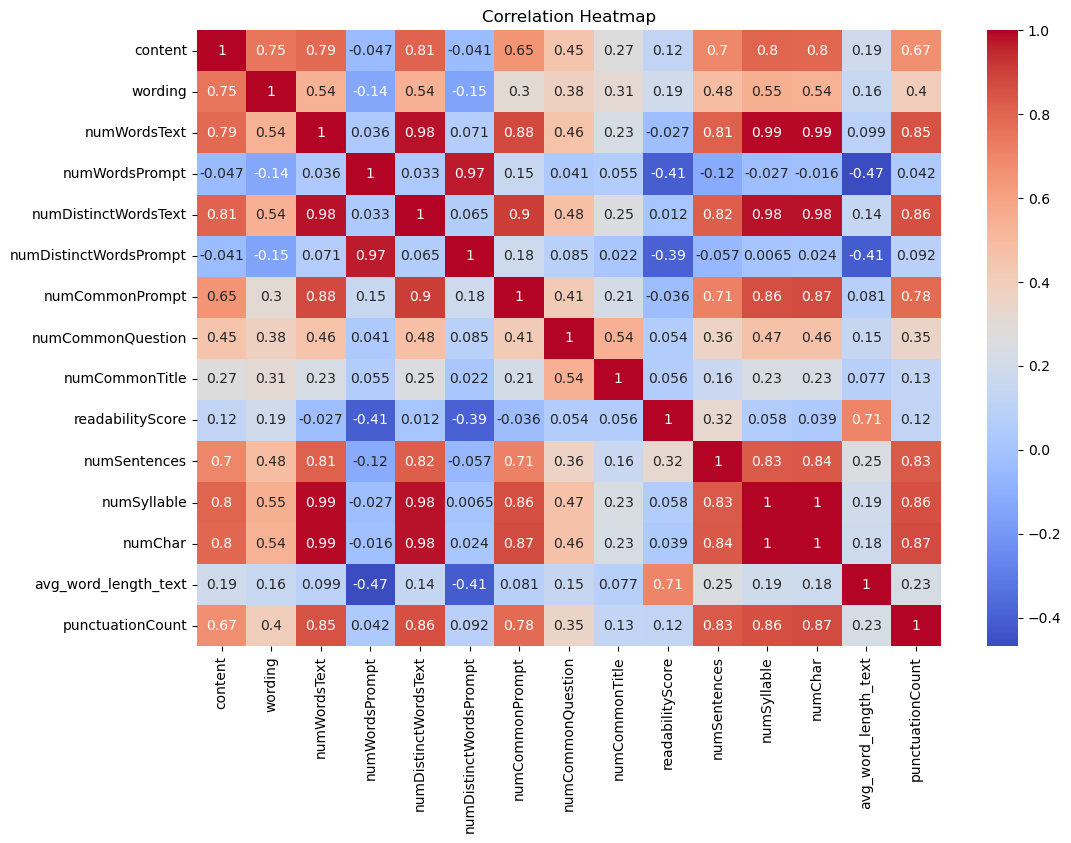

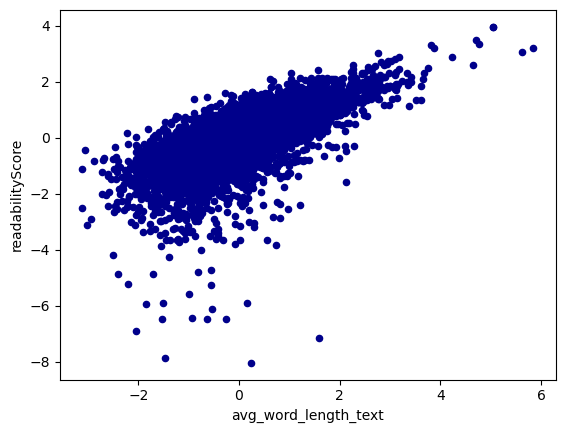

Correlation between readability and word length:
0.7069426372249253


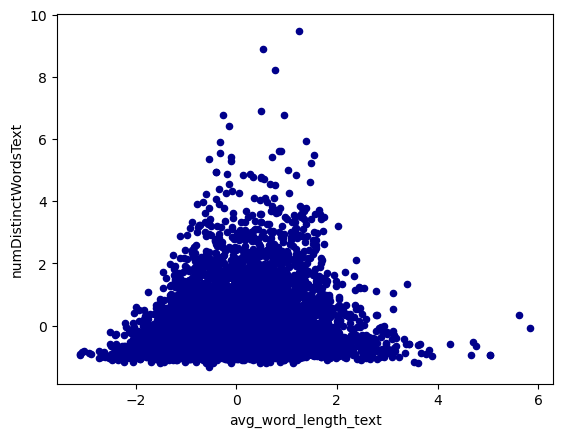

Correlation between readability and word length:
0.14065847107914112


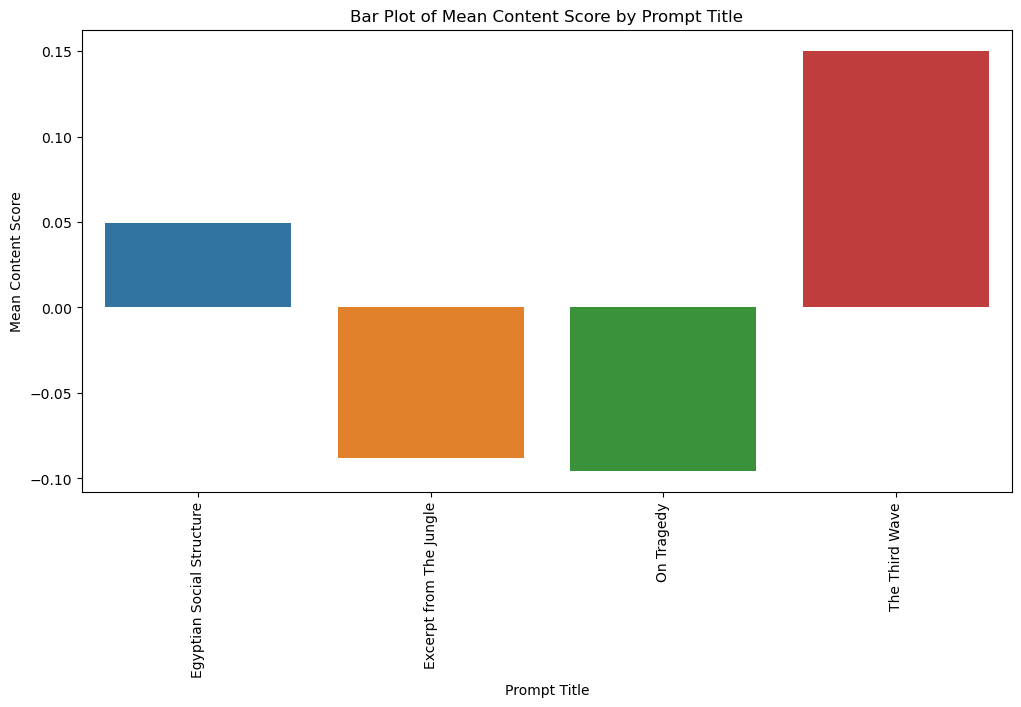

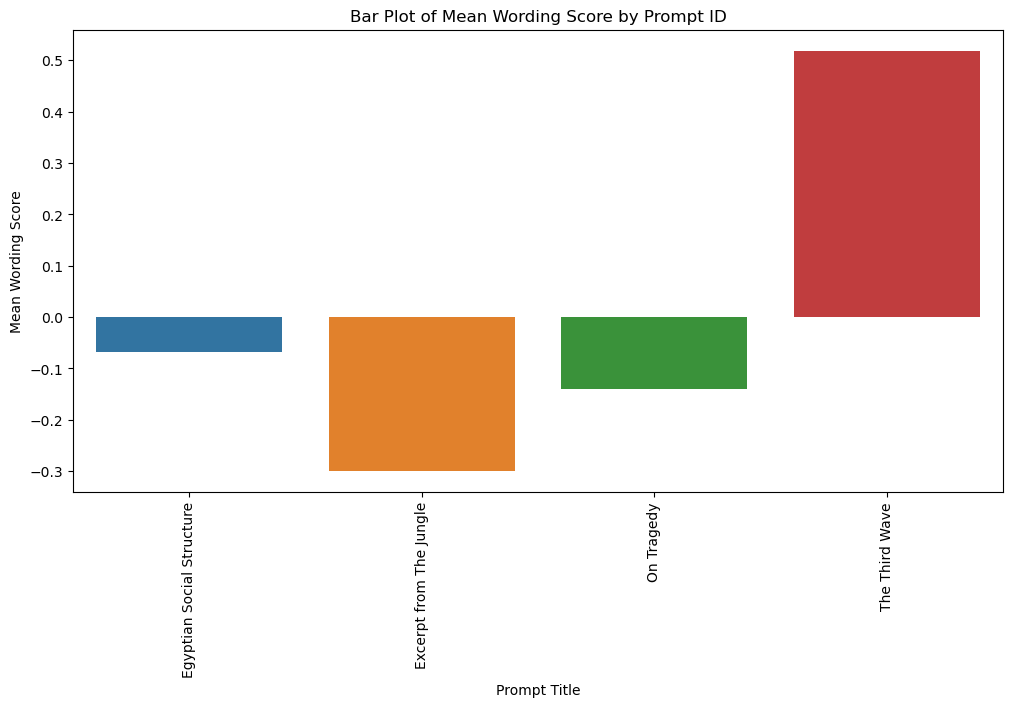

In [42]:
#Make Charts

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kstest, norm

numerical_features = ['numWordsText', 'numWordsPrompt', 'numDistinctWordsText','numDistinctWordsPrompt', 'numCommonPrompt','numCommonQuestion','numCommonTitle',
                      'numSentences','numSyllable','readabilityScore','numChar','avg_word_length_text']

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#Plot pair plots for the numerical features
#plt.figure(figsize=(12, 8))
#sns.pairplot(df[numerical_features + ['content', 'wording']])
#plt.suptitle('Pair Plot of Numerical Features', y=1.02)
#plt.show()

#scatter-Word Length & Readability
scat = df.plot.scatter(x='avg_word_length_text',y='readabilityScore',c='DarkBlue')
plt.show()
correlation = df['avg_word_length_text'].corr(df['readabilityScore'])
print("Correlation between readability and word length:")
print(correlation)

#scatter-Word length & Distinct Words
scat = df.plot.scatter(x='avg_word_length_text',y='numDistinctWordsText',c='DarkBlue')
plt.show()
correlation = df['avg_word_length_text'].corr(df['numDistinctWordsText'])
print("Correlation between readability and word length:")
print(correlation)

# Violin plot for content scores by prompt_id
#plt.figure(figsize=(10, 6))
#sns.violinplot(x='prompt_title', y='content', data=df)
#plt.title('Violin Plot of Content Scores by Prompt ID')
#plt.show()

# Violin plot for wording scores by prompt_id
#plt.figure(figsize=(10, 6))
#sns.violinplot(x='prompt_title', y='wording', data=df)
#plt.title('Violin Plot of Wording Scores by Prompt ID')
#plt.show()

# Calculate mean content score by prompt ID
mean_content_by_prompt = df.groupby('prompt_title')['content'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='prompt_title', y='content', data=mean_content_by_prompt)
plt.title('Bar Plot of Mean Content Score by Prompt Title')
plt.xlabel('Prompt Title')
plt.ylabel('Mean Content Score')
plt.xticks(rotation=90)
plt.show()

mean_wording_by_prompt = df.groupby('prompt_title')['wording'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='prompt_title', y='wording', data=mean_wording_by_prompt)
plt.title('Bar Plot of Mean Wording Score by Prompt ID')
plt.xlabel('Prompt Title')
plt.ylabel('Mean Wording Score')
plt.xticks(rotation=90)
plt.show()




## **Section 6: Baseline Model (Q7, 10 points)**

In [38]:
# Define features and targets
features = ['numWordsText', 'numWordsPrompt', 'numDistinctWordsText', 
            'numDistinctWordsPrompt', 'numCommonPrompt','numCommonQuestion','numCommonTitle']

X = df[features]
y_content = df['content']
y_wording = df['wording']

# Split the data
X_train, X_test, y_content_train, y_content_test = train_test_split(X, y_content, test_size=0.2, random_state=42)
_, _, y_wording_train, y_wording_test = train_test_split(X, y_wording, test_size=0.2, random_state=42)

# Train and evaluate the model for content
content_model = LinearRegression()
content_model.fit(X_train, y_content_train)
y_content_pred = content_model.predict(X_test)
content_mse = mean_squared_error(y_content_test, y_content_pred)

# Train and evaluate the model for wording
wording_model = LinearRegression()
wording_model.fit(X_train, y_wording_train)
y_wording_pred = wording_model.predict(X_test)
wording_mse = mean_squared_error(y_wording_test, y_wording_pred)

# Report the mean squared error
print(f"Mean Squared Error for Content Model: {content_mse}")
print(f"Mean Squared Error for Wording Model: {wording_mse}")

Mean Squared Error for Content Model: 0.3089124917060882
Mean Squared Error for Wording Model: 0.4820126581010425


## **Section 7: Feature Cleaning and Additional Models (Q8 & Q9, 20 points total)**

In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select the numerical columns to normalize
numerical_features = ['numWordsText', 'numWordsPrompt', 'numDistinctWordsText','numDistinctWordsPrompt', 'numCommonPrompt','numCommonQuestion','numCommonTitle',
                      'numSentences','numSyllable','readabilityScore','numChar','avg_word_length_text']

# Option 1: StandardScaler (mean=0, variance=1)
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


# Define features and targets

X = df[numerical_features]
y_content = df['content']
y_wording = df['wording']

# Split the data
X_train, X_test, y_content_train, y_content_test = train_test_split(X, y_content, test_size=0.2, random_state=42)
_, _, y_wording_train, y_wording_test = train_test_split(X, y_wording, test_size=0.2, random_state=42)

# Train and evaluate the model for content
content_model = LinearRegression()
content_model.fit(X_train, y_content_train)
y_content_pred = content_model.predict(X_test)
content_mse1 = mean_squared_error(y_content_test, y_content_pred)

# Train and evaluate the model for wording
wording_model = LinearRegression()
wording_model.fit(X_train, y_wording_train)
y_wording_pred = wording_model.predict(X_test)
wording_mse1 = mean_squared_error(y_wording_test, y_wording_pred)

# Report the mean squared error
print(f"Mean Squared Error for Content Model: {content_mse1}")
print(f"Mean Squared Error for Wording Model: {wording_mse1}")
# Confirm normalization



Mean Squared Error for Content Model: 0.29515455179850464
Mean Squared Error for Wording Model: 0.45414698636843864


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Select the numerical columns to normalize
numerical_features = ['numWordsText', 'numWordsPrompt', 'numDistinctWordsText','numDistinctWordsPrompt', 'numCommonPrompt','numCommonQuestion','numCommonTitle',
                      'numSentences','numSyllable','readabilityScore','numChar','avg_word_length_text','punctuationCount','readabilityScore']

# Option 1: StandardScaler (mean=0, variance=1)
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


# Define features and targets

X = df[numerical_features]
y_content = df['content']
y_wording = df['wording']

X_train, X_test, y_content_train, y_content_test = train_test_split(X, y_content, test_size=0.2, random_state=42)
_, _, y_wording_train, y_wording_test = train_test_split(X, y_wording, test_size=0.2, random_state=42)


# Train and evaluate the model for content
content_model = RandomForestRegressor(random_state=42)
content_model.fit(X_train, y_content_train)
y_content_pred = content_model.predict(X_test)
content_mse2 = mean_squared_error(y_content_test, y_content_pred)
content_r2 = r2_score(y_content_test,y_content_pred)
# Train and evaluate the model for wording
wording_model = RandomForestRegressor(random_state=42)
wording_model.fit(X_train, y_wording_train)
y_wording_pred = wording_model.predict(X_test)
wording_mse2 = mean_squared_error(y_wording_test, y_wording_pred)
wording_r2 = r2_score(y_wording_test,y_wording_pred)

# Report the mean squared error
print(f"Mean Squared Error for Content Model: {content_mse2}")
print(f"Mean Squared Error for Wording Model: {wording_mse2}")
print(f"r2 score for Content Model: {content_r2}")
print(f"r2 score for Wording Model: {wording_r2}")

Mean Squared Error for Content Model: 0.2033826840975803
Mean Squared Error for Wording Model: 0.37477823712458846
r2 score for Content Model: 0.8121861503489323
r2 score for Wording Model: 0.6317177187165828


In [51]:
print("difference between mse's")
print(f"MSE Difference between regression and forest for Content Model: {content_mse1-content_mse2}")
print(f"MSE Difference between regression and forst for Wording Model: {wording_mse1-wording_mse2}")

difference between mse's
MSE Difference between regression and forest for Content Model: 0.09177186770092433
MSE Difference between regression and forst for Wording Model: 0.07936874924385018


## **Section 8: Kaggle Submission Screenshots (Q10, 5 points)**

Public Score:

Private Score:

Kaggle profile link:

Screenshot(s):